<a href="https://colab.research.google.com/github/bs3537/dengueAI/blob/master/V11_San_Juan_XGB_environmental_and_time_features_PDP_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
#https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/

In [0]:
#Your goal is to predict the total_cases label for each (city, year, weekofyear) in the test set. 

In [0]:
#Performance metric = mean absolute error

##LIST OF FEATURES:
You are provided the following set of information on a (year, weekofyear) timescale:

(Where appropriate, units are provided as a _unit suffix on the feature name.)

###City and date indicators
1. city – City abbreviations: sj for San Juan and iq for Iquitos
2. week_start_date – Date given in yyyy-mm-dd format
###NOAA's GHCN daily climate data weather station measurements
1. station_max_temp_c – Maximum temperature
2. station_min_temp_c – Minimum temperature
3. station_avg_temp_c – Average temperature
4. station_precip_mm – Total precipitation
5. station_diur_temp_rng_c – Diurnal temperature range

###PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)

6. precipitation_amt_mm – Total precipitation

###NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)

7. reanalysis_sat_precip_amt_mm – Total precipitation
8. reanalysis_dew_point_temp_k – Mean dew point temperature
9. reanalysis_air_temp_k – Mean air temperature
10. reanalysis_relative_humidity_percent – Mean relative humidity
11. reanalysis_specific_humidity_g_per_kg – Mean specific humidity
12. reanalysis_precip_amt_kg_per_m2 – Total precipitation
13. reanalysis_max_air_temp_k – Maximum air temperature
14. reanalysis_min_air_temp_k – Minimum air temperature
15. reanalysis_avg_temp_k – Average air temperature
16. reanalysis_tdtr_k – Diurnal temperature range

###Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
17. ndvi_se – Pixel southeast of city centroid
18. ndvi_sw – Pixel southwest of city centroid
19. ndvi_ne – Pixel northeast of city centroid
20. ndvi_nw – Pixel northwest of city centroid

####TARGET VARIABLE = total_cases label for each (city, year, weekofyear)

In [0]:
import sys

In [0]:
#Load train features and labels datasets
train_features = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_train.csv')

In [0]:
train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [0]:
train_features.shape

(1456, 24)

In [0]:
train_labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_labels_train.csv')

In [0]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [0]:
train_labels.shape

(1456, 4)

In [0]:
#Merge train features and labels datasets

In [0]:
train = pd.merge(train_features, train_labels)

In [0]:
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [0]:
train.shape
#city, year and week of year columns are duplicate in train_features and train_labels datasets so the total_cases column is added to the features dataset

(1456, 25)

In [0]:
train.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [0]:
#Data rows for San Juan 
train.city.value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [0]:
#San Juan has 936 rows which we can isolate and analyze separately

In [0]:
train = train[train['city'].str.match('sj')]

In [0]:
train.head(5)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [0]:
train.shape

(936, 25)

In [0]:
#Thus, we have isolated the train dataset with only city data for San Juan

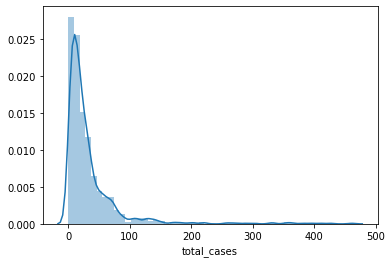

In [0]:
#Distribution of the target
import seaborn as sns
sns.distplot(train['total_cases'])

In [0]:
#The target distribution is skewed

In [0]:
#Find outliers
train['total_cases'].describe()

count    936.000000
mean      34.180556
std       51.381372
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64

In [0]:
#Remove outliers
train = train[(train['total_cases'] >= np.percentile(train['total_cases'], 0.5)) & 
        (train['total_cases'] <= np.percentile(train['total_cases'], 99.5))]  

In [0]:
train.shape

(927, 25)

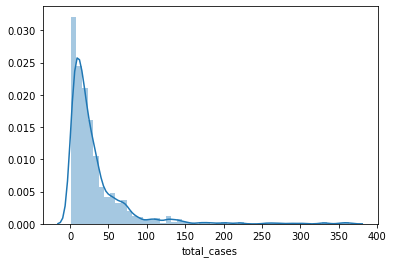

In [0]:
sns.distplot(train['total_cases'])

In [0]:
#Do train, val split
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              random_state=42)
train.shape, val.shape

((741, 25), (186, 25))

In [0]:
#Load test features dataset (for the competition)
test = pd.read_csv('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_test.csv')

In [0]:
#Pandas Profiling


#####Baseline statistics (mean and MAE) for the target variable total_cases in train dataset and baseline validation MAE

In [0]:
train['total_cases']. describe()

count    741.000000
mean      31.582996
std       40.668870
min        1.000000
25%        9.000000
50%       18.000000
75%       38.000000
max      364.000000
Name: total_cases, dtype: float64

In [0]:
#Baseline mean and mean absolute error

In [0]:
guess = train['total_cases'].mean()
print(f'At the baseline, the mean total number of dengue cases in a year is: {guess:.2f}')

At the baseline, the mean total number of dengue cases in a year is: 31.58


In [0]:
#If we had just guessed that the total number of dengue cases was 31.58 for a city in a particular year, we would be off by how much?

In [0]:
from sklearn.metrics import mean_absolute_error

# Arrange y target vectors
target = 'total_cases'
y_train = train[target]
y_val = val[target]

# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train mean absolute error: {mae:.2f} dengue cases per year')

# Test Error
y_pred = [guess] * len(y_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation mean absolute error: {mae:.2f} dengue cases per year')

Mean Baseline (using 0 features)
Train mean absolute error: 24.94 dengue cases per year
Validation mean absolute error: 26.96 dengue cases per year


In [0]:
#we need to convert week_start_date to numeric form uisng pd.to_dateime function
#wrangle function 

def wrangle(X):
  X = X.copy()
       
    # Convert week_start_date to numeric form
  X['week_start_date'] = pd.to_datetime(X['week_start_date'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['week_start_date'].dt.year
  X['month_recorded'] = X['week_start_date'].dt.month
  #X['day_recorded'] = X['week_start_date'].dt.day
  X = X.drop(columns='week_start_date')
  X = X.drop(columns='year')
  X = X.drop(columns='station_precip_mm')

#I engineered few features which represent standing water, high risk feature for mosquitos

  #1. X['standing water feature 1'] = X['station_precip_mm'] / X['station_max_temp_c']

  #Standing water features
  X['total satellite vegetation index of city'] = X['ndvi_se'] + X['ndvi_sw'] + X['ndvi_ne'] + X['ndvi_nw']

  #Standing water features

  #Standing water feature 1 = 'NOAA GCN precipitation amount in kg per m2 reanalyzed' * (total vegetation, sum of all 4 parts of the city)
  X['standing water feature 1'] = X['reanalysis_precip_amt_kg_per_m2'] * X['total satellite vegetation index of city'] 
  #Standing water feature 2: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'}
  X['standing water feature 2'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent']   
  #Standing water feature 3: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'} * (total vegetation)
  X['standing water feature 3'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent'] * X['total satellite vegetation index of city']  
  #Standing water feature 4: 'NOAA GCN precipitation amount in kg per m2 reanalyzed'} / 'NOAA GCN max air temp reanalyzed'
  X['standing water feature 4'] = X['reanalysis_precip_amt_kg_per_m2'] / X['reanalysis_max_air_temp_k']
  #Standing water feature 5: ['NOAA GCN precipitation amount in kg per m2 reanalyzed'} * 'NOAA GCN mean relative humidity in pct reanalyzed'} * (total vegetation)]/['NOAA GCN max air temp reanalyzed']
  X['standing water feature 5'] = X['reanalysis_precip_amt_kg_per_m2'] * X['reanalysis_relative_humidity_percent'] * X['total satellite vegetation index of city'] / X['reanalysis_max_air_temp_k']

  
  #Rename columns
  X.rename(columns= {'reanalysis_air_temp_k':'Mean air temperature in K'}, inplace=True)
  X.rename(columns= {'reanalysis_min_air_temp_k':'Minimum air temperature in K'}, inplace=True)
  X.rename(columns= {'weekofyear':'Week of Year'}, inplace=True)
  X.rename(columns= {'station_diur_temp_rng_c':'Diurnal temperature range in C'}, inplace=True)
  X.rename(columns= {'reanalysis_precip_amt_kg_per_m2':'Total precipitation kg/m2'}, inplace=True)
  X.rename(columns= {'reanalysis_tdtr_k':'Diurnal temperature range in K'}, inplace=True)
  X.rename(columns= {'reanalysis_max_air_temp_k':'Maximum air temperature in K'}, inplace=True)
  X.rename(columns= {'year_recorded':'Year recorded'}, inplace=True)
  X.rename(columns= {'reanalysis_relative_humidity_percent':'Mean relative humidity'}, inplace=True)
  X.rename(columns= {'month_recorded':'Month recorded'}, inplace=True)
  X.rename(columns= {'reanalysis_dew_point_temp_k':'Mean dew point temp in K'}, inplace=True)
  X.rename(columns= {'precipitation_amt_mm':'Total precipitation in mm'}, inplace=True)
  X.rename(columns= {'station_min_temp_c':'Minimum temp in C'}, inplace=True)
  X.rename(columns= {'ndvi_se':'Southeast vegetation index'}, inplace=True)
  X.rename(columns= {'ndvi_ne':'Northeast vegetation index'}, inplace=True)
  X.rename(columns= {'ndvi_nw':'Northwest vegetation index'}, inplace=True)
  X.rename(columns= {'ndvi_sw':'Southwest vegetation index'}, inplace=True)
  X.rename(columns= {'reanalysis_avg_temp_k':'Average air temperature in K'}, inplace=True)
  X.rename(columns= {'reanalysis_sat_precip_amt_mm':'Total precipitation in mm (2)'}, inplace=True)
  X.rename(columns= {'reanalysis_specific_humidity_g_per_kg':'Mean specific humidity'}, inplace=True)
  X.rename(columns= {'station_avg_temp_c':'Average temp in C'}, inplace=True)
  X.rename(columns= {'station_max_temp_c':'Maximum temp in C'}, inplace=True)
  X.rename(columns= {'total_cases':'Total dengue cases in the week'}, inplace=True) 

  #Drop columns
  X = X.drop(columns='Total precipitation in mm (2)')
  X = X.drop(columns='Average temp in C')
  X = X.drop(columns='Maximum temp in C')
  X = X.drop(columns='Minimum temp in C')
  X = X.drop(columns='Diurnal temperature range in C')
  X = X.drop(columns='Average air temperature in K')
  X = X.drop(columns='city')





    # return the wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
train.head().T

,853,97,552,675,597
Week of Year,38.000000,11.000000,49.000000,17.000000,43.000000
Northeast vegetation index,-0.055600,0.086850,0.118750,-0.078000,-0.014100
Northwest vegetation index,-0.016200,0.090150,0.080600,-0.125200,0.212100
Southeast vegetation index,0.197700,0.128000,0.117633,0.148671,0.252900
Southwest vegetation index,0.171929,0.155100,0.046117,0.159471,0.222829
Total precipitation in mm,27.180000,23.220000,19.690000,389.600000,39.700000
Mean air temperature in K,301.418571,297.634286,299.702857,298.445714,300.258571
Mean dew point temp in K,296.721429,293.540000,295.402857,295.482857,296.530000
Maximum air temperature in K,303.600000,299.600000,301.500000,301.400000,302.200000
Minimum air temperature in K,299.200000,296.100000,297.900000,296.300000,298.400000


In [0]:
train.dtypes

Week of Year                                  int64
Northeast vegetation index                  float64
Northwest vegetation index                  float64
Southeast vegetation index                  float64
Southwest vegetation index                  float64
Total precipitation in mm                   float64
Mean air temperature in K                   float64
Mean dew point temp in K                    float64
Maximum air temperature in K                float64
Minimum air temperature in K                float64
Total precipitation kg/m2                   float64
Mean relative humidity                      float64
Mean specific humidity                      float64
Diurnal temperature range in K              float64
Total dengue cases in the week                int64
Year recorded                                 int64
Month recorded                                int64
total satellite vegetation index of city    float64
standing water feature 1                    float64
standing wat

In [0]:
#Before we build the model to train on train dataset, log transform target variable due to skew

In [0]:
import numpy as np
target_log = np.log1p(train['Total dengue cases in the week'])

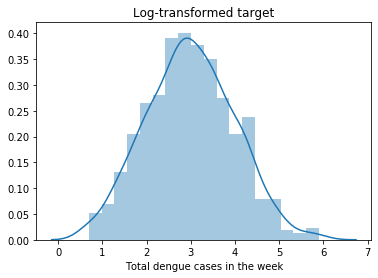

In [0]:
sns.distplot(target_log)
plt.title('Log-transformed target');

In [0]:
target_log_series = pd.Series(target_log)

In [0]:
train = train.assign(log_total_cases = target_log_series)

In [0]:
#drop total_cases target column while training the model
train = train.drop(columns='Total dengue cases in the week')

In [0]:
#Do the same log transformation with validation dataset
target_log_val = np.log1p(val['Total dengue cases in the week'])

In [0]:
target_log_val_series = pd.Series(target_log_val)

In [0]:
val = val.assign(log_total_cases = target_log_val_series)

In [0]:
val = val.drop(columns='Total dengue cases in the week')

In [0]:
#Fitting XGBoost Regresser model

In [0]:
#Define target and features

In [0]:
# The status_group column is the target
target = 'log_total_cases'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()


# Combine the lists 
features = numeric_features



In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]


In [0]:
pip install category_encoders

     |████████████████████████████████| 102kB 2.8MB/s 


In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import model_selection, preprocessing

In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBRegressor(n_estimators=137, objective='reg:squarederror', n_jobs=-1)
)

In [0]:
pipeline.fit(X_train, y_train)

In [0]:
#predict on X_val
y_pred = pipeline.predict(X_val)

In [0]:
print('XGBoost Validation Mean Absolute Error, log transformed)', mean_absolute_error(y_val, y_pred))

XGBoost Validation Mean Absolute Error, log transformed) 0.3945765884474653


In [0]:
#Transform y_pred back to original units from log transformed
y_pred_original = np.expm1(y_pred)

In [0]:
y_val_original = np.expm1(y_val)

In [0]:
print('XGBoost Validation Mean Absolute Error (non-log transformed)', mean_absolute_error(y_val_original, y_pred_original))

XGBoost Validation Mean Absolute Error (non-log transformed) 14.980486976203096


In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
pip install pdpbox

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [0]:
feature='Week of Year'

isolated = pdp_isolate(
    model = pipeline,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc3e09f9a90>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc3e0a30c50>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


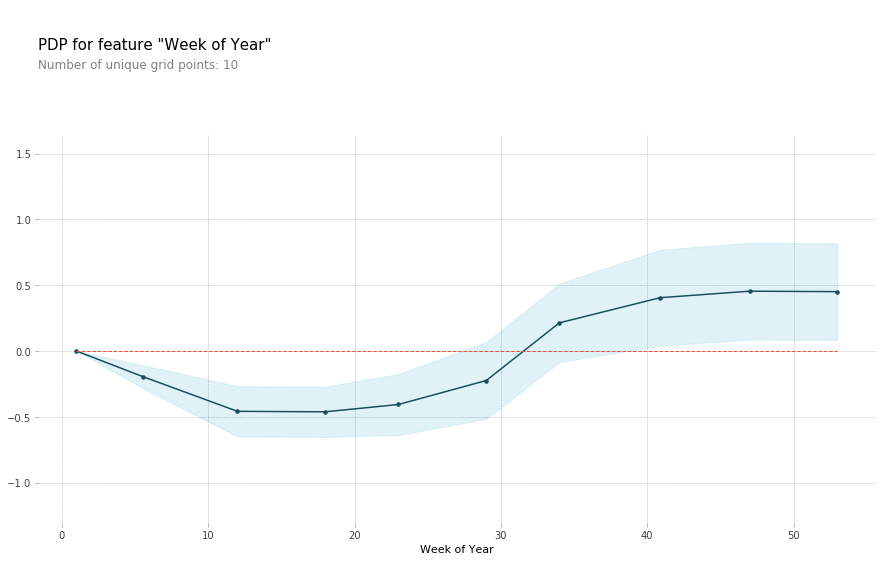

In [0]:
pdp_plot(isolated, feature_name=feature)